[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# <center> **DETECCIÓN TEMPRANA DE ALZHEIMER** </center>

<center> <img src="https://cdn.discordapp.com/attachments/691797192041562122/1019021690161864775/banner.jpg" width="100%"></center> 

El análisis de los cerebros por medio de escáneres ha demostrado que la pérdida de materia gris en el hemisferio izquierdo del cerebro es particularmente importante y dañina, con riesgo alto de desarrollar Alzheimer. El hemisferio izquierdo del cerebro está asociado a las funciones del lenguaje, toma de decisiones, personalidad, movimiento, conducta social y funciones cognitivas complejas. La pérdida constante de células en las regiones del cerebro indicadas por el estudio (el giro parahipocampal), deberían hacer sonar las alarmas de los doctores, pues podrían indicar que su paciente acabará padeciendo Alzheimer. Esta región debería ser analizada cuidadosamente en los escáneres cerebrales para detectar signos precoces de la enfermedad. 


<center><img src="https://agenciadenoticias.unal.edu.co/uploads/pics/AgenciaNoticias-20161026-01_07.jpg" width="650px"></center> 

Nuestro objetivo será procesar una MRI (Imagen de Resonancia Magnética, por sus siglas en inglés) cerebral para detectar la materia gris y blanca. Esto ayudará a determinar la cantidad de ambas, y con ello ver su evolución en el tiempo para un mismo paciente y de esta manera obtener una detección temprana y tratamiento de esta enfermedad llegado el caso de padecerla. 

#Paquetes y librerías

In [ ]:
#@title paquetes
!pip install -q wget

In [ ]:
#@title librerías
import wget
import zipfile
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

#Dataset

In [ ]:
#@title cargar el dataset
url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
#@title traer las imagenes del zip que se cargó
path = Path('./MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

print("Cantidad de imágenes del DataSet: ",len(imgs))
print("Muestra de lo que contiene: \n")
print("\tMRIs\t\t\t\t\t\tMasks")

print(imgs[0],"\t\t\t",masks[0])

Cantidad de imágenes del DataSet:  425
Muestra de lo que contiene: 

	MRIs						Masks
MRIs/MRIs/img_346.npy 			 MRIs/Segmentations/segm_346.npy


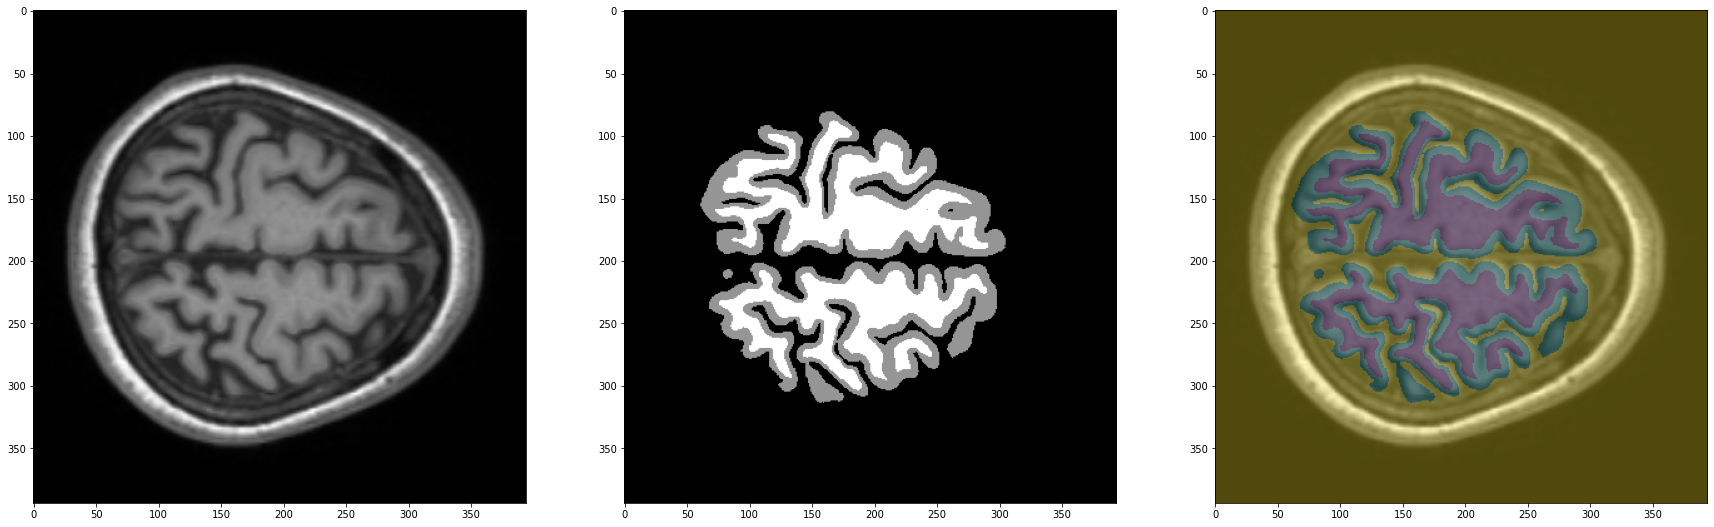

In [ ]:
#@title visualizar un ejemplo de lo que contiene el dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img, cmap="gray")
ax2.imshow(mask, cmap="Greys")
ax3.imshow(img, cmap="gray")
ax3.imshow(mask, alpha=0.32)
plt.show()

In [ ]:
#@title propiedades de las imagenes
print("Dimensiones de la MRI: ",img.shape)
print("Tipo de dato: ",img.dtype)
print("Valor máximo: ",img.max())
print("Valor mínimo: ",img.min())

Dimensiones de la MRI:  (394, 394)
Tipo de dato:  float32
Valor máximo:  1.1114025
Valor mínimo:  0.00025629325


In [ ]:
#@title propiedades de las máscaras
print("Dimensiones de la máscara: ",mask.shape)
print("Tipo de dato: ",mask.dtype)
print("Valor máximo: ",mask.max())
print("Valor mínimo: ",mask.min())

Dimensiones de la máscara:  (394, 394)
Tipo de dato:  uint8
Valor máximo:  2
Valor mínimo:  0


#Pre-procesamiento de los datos

In [ ]:
#@title se redimensiona cada imagen y máscara 2-D -> 1-D
imgsVector = [] 
masksVector = []
NewSizeImagen = (294,294)
for i in range(0,len(imgs)):
  imgsVector.append(cv2.resize(np.load(imgs[i]), (NewSizeImagen)).flatten(order='C'))
  masksVector.append(cv2.resize(np.load(masks[i]), (NewSizeImagen)).flatten(order='C'))

In [ ]:
#@title propiedades de las máscaras
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

#Seleccionar datos de entrenamiento

##Entrenamiento de modelos con una imagen

In [ ]:
#@title seleccionar una imagen para el entrenamiento
indexImg_train_A = 0 #@param {type:"int"})
x_train_A = imgsVector[indexImg_train_A]
y_train_A = masksVector[indexImg_train_A]

##Entrenamiento de modelos con más de una imagen


In [ ]:
#@title Seleccionar número de imágenes para entrenamiento
num_imgs = 5 #@param {type:"int"})
x_train_B = imgsVector[0:num_imgs]
y_train_B = masksVector[0:num_imgs]

#Métricas de efectividad

In [ ]:
#@title metrica IoU
def iou(imgPred, imgTrue):
  vectorInterseccion = []
  union = len(imgTrue)
  c = np.equal(imgPred, imgTrue)
  num_inter = len([element for element in c if element == True])
  return (num_inter/union)

#Modelos

##1. Decision Tree classifier


###DTC Modelo A (entrenamiento con una imágen)

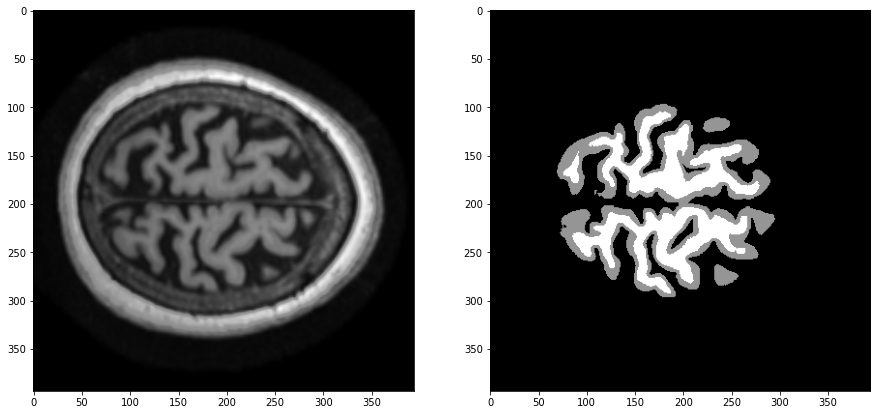

In [ ]:
#@title visualizar la imágen y máscara seleccionada para entrenar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
img1 = np.load(imgs[indexImg_train_A])
mask1 = np.load(masks[indexImg_train_A])
ax1.imshow(img1, cmap='gray')
ax2.imshow(mask1, cmap='Greys')
plt.show()

In [ ]:
#@title definir y entrenar el modelo
dtc_a = DecisionTreeClassifier(criterion='gini')
dtc_a.fit(x_train_A.reshape(-1, 1),y_train_A.reshape(-1, 1))

DecisionTreeClassifier()

In [ ]:
#@title seleccionar una imágen y máscara para testear 
indexImg_dtc_A = 25 #@param {type:"int"})
x_test_dtc_A = imgsVector[indexImg_dtc_A]
y_test_dtc_A = masksVector[indexImg_dtc_A]

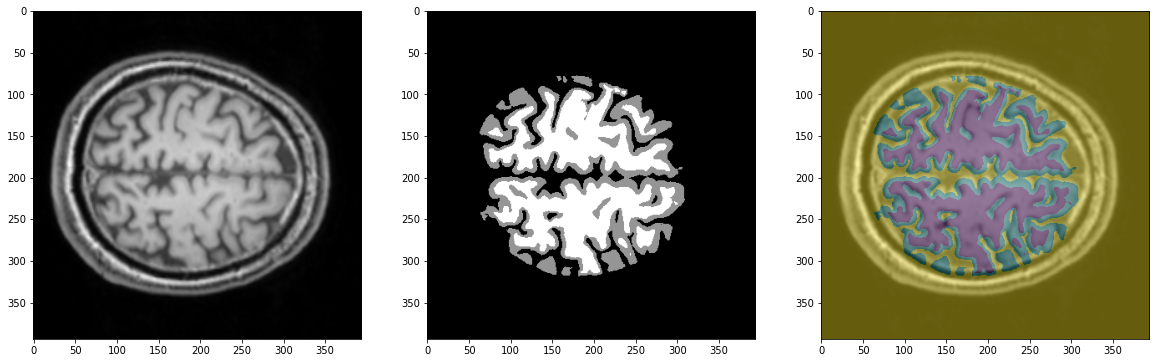

In [ ]:
#@title visualizar la imágen y máscara seleccionada para el test
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,12))
img1 = np.load(imgs[indexImg_dtc_A])
mask1 = np.load(masks[indexImg_dtc_A])
ax1.imshow(img1, cmap='gray')
ax2.imshow(mask1, cmap='Greys')
ax3.imshow(img1, cmap='gray')
ax3.imshow(mask1, alpha=0.4)
plt.show()

86436
accuracy:  0.7578092461474386
metrica IoU:  0.7578092461474386
recall:  0.49625797074422096
[[ 3041  4338  3691]
 [  745  3014  6050]
 [ 1109  5001 59447]]


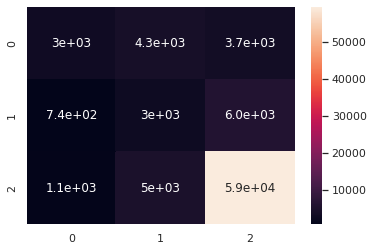

In [ ]:
#@title realizar una predicción con el modelo 
pred_dtc_a = dtc_a.predict(x_test_dtc_A.reshape(-1, 1))
accuracy_dtc_a = accuracy_score(pred_dtc_a, y_test_dtc_A)
recall_dtc_a = recall_score(y_test_dtc_A, pred_dtc_a, average='macro')
iou_metric_a = iou(pred_dtc_a, y_test_dtc_A)
sns.set()
f,ax=plt.subplots()
cm = confusion_matrix(y_test_dtc_A, pred_dtc_a)
sns.heatmap(cm,annot=True,ax=ax) 
print('accuracy: ', accuracy_dtc_a)
print('metrica IoU: ', iou_metric_a)
print('recall: ', recall_dtc_a)
print(cm)

In [ ]:
#@title diferencias de mascaras
SobranteError = pred_dtc_a.reshape(NewSizeImagen)-y_test_dtc_A.reshape(NewSizeImagen)

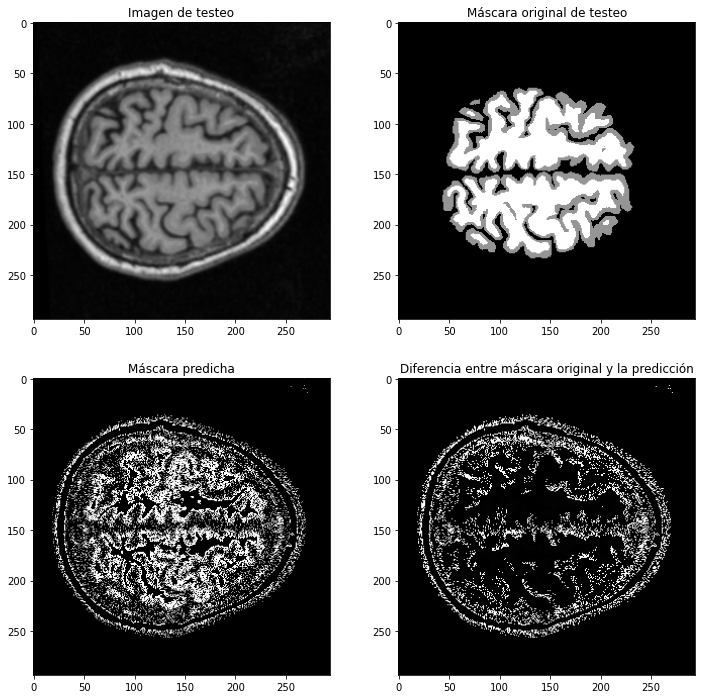

In [ ]:
#@title visualizar las imágenes de testeo y la predicción
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12,12))
ax1.imshow(x_test_dtc_A.reshape(NewSizeImagen), cmap='gray')
ax2.imshow(y_test_dtc_A.reshape(NewSizeImagen), cmap='Greys')
ax3.imshow(pred_dtc_a.reshape(NewSizeImagen), cmap='Greys')
ax4.imshow(SobranteError, cmap='gray')
ax1.set_title('Imagen de testeo')
ax2.set_title('Máscara original de testeo')
ax3.set_title('Máscara predicha')
ax4.set_title('Diferencia entre máscara original y la predicción')
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0692677 to fit


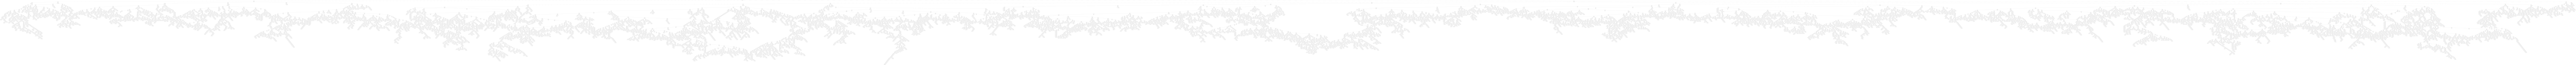

In [ ]:
#@title **code** Visualize the resultant tree
#!sudo apt-get install graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
export_graphviz(dtc_a, out_file='tree_c.dot', feature_names=x_train_A.reshape(-1, 1)[0])
!dot -Tpng tree_c.dot > tree_c.png

Image(filename='tree_c.png') 

####Observación a destacar

#####Si realizamos la predicción para la imágen usada para entrenar, la predicción obtenida se ajusta al resultado esperado. Al utilizar una imágen distinta del dataset se puede observar que no se obtiene una buena predicción.

In [ ]:
#@title diferencias de mascaras
SobranteError1 = dtc_a.predict(x_train_A.reshape(-1, 1)).reshape(NewSizeImagen)-y_train_A.reshape(NewSizeImagen)

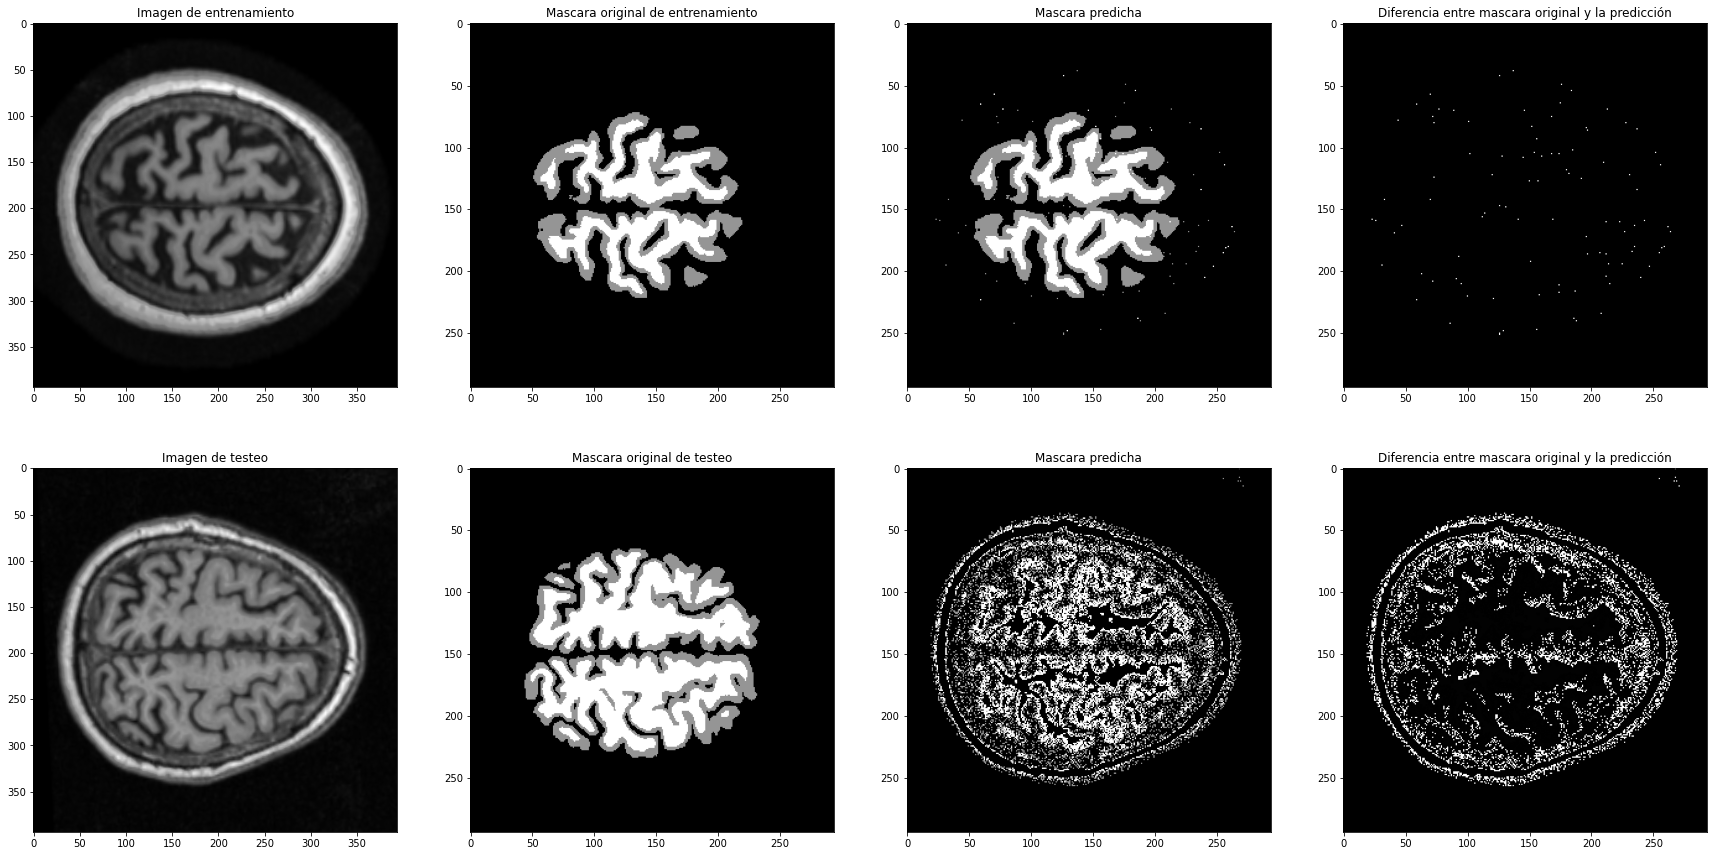

In [ ]:
#@title visualización total de observaciones
fig, ([[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]]) = plt.subplots(2, 4, figsize=(30,15))
ax1.imshow(np.load(imgs[indexImg_train_A]), cmap='gray')
ax2.imshow(y_train_A.reshape(NewSizeImagen), cmap='Greys')
ax3.imshow(dtc_a.predict(x_train_A.reshape(-1, 1)).reshape(NewSizeImagen), cmap='Greys')
ax4.imshow(SobranteError1, cmap='gray')
ax5.imshow(np.load(imgs[indexImg_dtc_A]), cmap='gray')
ax6.imshow(y_test_dtc_A.reshape(NewSizeImagen), cmap='Greys')
ax7.imshow(pred_dtc_a.reshape(NewSizeImagen), cmap='Greys')
ax8.imshow(SobranteError, cmap='gray')
ax1.set_title('Imagen de entrenamiento')
ax2.set_title('Mascara original de entrenamiento')
ax3.set_title('Mascara predicha')
ax4.set_title('Diferencia entre mascara original y la predicción')
ax5.set_title('Imagen de testeo')
ax6.set_title('Mascara original de testeo')
ax7.set_title('Mascara predicha')
ax8.set_title('Diferencia entre mascara original y la predicción')
plt.show()

#####Por ello sería necesario entrenar el modelo con más de una imágen y que de esta manera no se sesgue a poder predecir una única imágen.

###DTC Modelo B (entrenamiento con más de una imágen)

In [ ]:
#@title definir y entrenar el modelo 2
dtc_b = DecisionTreeClassifier(criterion='gini')
dtc_b.fit(x_train_B,y_train_B)

DecisionTreeClassifier()

In [ ]:
#@title seleccionar una imágen para realizar la prueba
indexImg_test_dtc_B = 25 #@param {type:"int"})
x_test_dtc_B = imgsVector[indexImg_test_dtc_B]
y_test_dtc_B = masksVector[indexImg_test_dtc_B]

In [ ]:
#@title Realizar una predicción con el modelo
pred_dtc_b = dtc_b.predict(x_test_dtc_B.reshape(1, -1))
accuracy_dtc_b = accuracy_score(pred_dtc_b.reshape(-1, 1), y_test_dtc_B.reshape(-1, 1))
recall_dtc_b = recall_score(y_test_dtc_B.reshape(-1, 1), pred_dtc_b.reshape(-1, 1), average='macro')
iou_metric_b = iou(pred_dtc_b.reshape(-1, 1), y_test_dtc_B.reshape(-1, 1))

print('accuracy: ', accuracy_dtc_b)
print('metrica IoU: ', iou_metric_b)
print('recall: ', recall_dtc_b)

accuracy:  0.8533944189920867
metrica IoU:  0.8533944189920867
recall:  0.6550441493010953


####Observación a destacar

#####Al igual que con el modelo A, al realizar la predicción para.

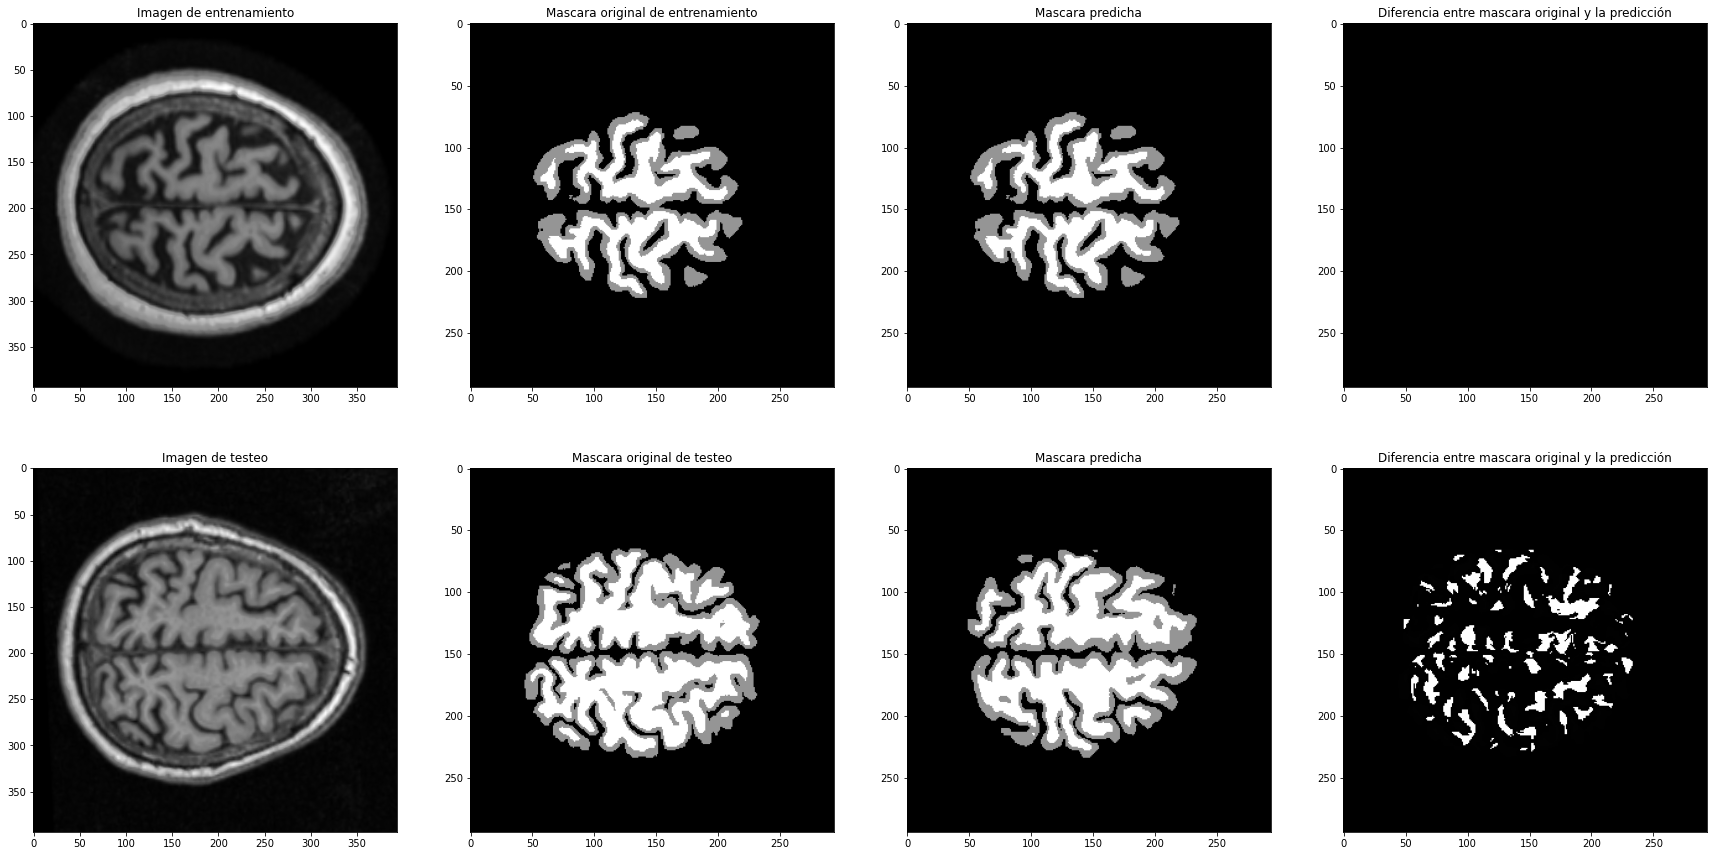

In [ ]:
#@title visualización total de observaciones
fig, ([[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]]) = plt.subplots(2, 4, figsize=(30,15))
ax1.imshow(np.load(imgs[indexImg_train_A]), cmap='gray')
ax2.imshow(y_train_B[0].reshape(NewSizeImagen), cmap='Greys')
ax3.imshow(dtc_b.predict(x_train_B[0].reshape(1, -1)).reshape(NewSizeImagen), cmap='Greys')
ax4.imshow(dtc_b.predict(x_train_B[0].reshape(1, -1)).reshape(NewSizeImagen)-y_train_B[0].reshape(NewSizeImagen), cmap='gray')
ax5.imshow(np.load(imgs[indexImg_test_dtc_B]), cmap='gray')
ax6.imshow(y_test_dtc_B.reshape(NewSizeImagen), cmap='Greys')
ax7.imshow(pred_dtc_b.reshape(NewSizeImagen), cmap='Greys')
ax8.imshow(pred_dtc_b.reshape(NewSizeImagen)-y_test_dtc_B.reshape(NewSizeImagen), cmap='gray')
ax1.set_title('Imagen de entrenamiento')
ax2.set_title('Mascara original de entrenamiento')
ax3.set_title('Mascara predicha')
ax4.set_title('Diferencia entre mascara original y la predicción')
ax5.set_title('Imagen de testeo')
ax6.set_title('Mascara original de testeo')
ax7.set_title('Mascara predicha')
ax8.set_title('Diferencia entre mascara original y la predicción')
plt.show()

##2. Random Forest Classifier

###RFC Modelo A (entrenamiento con una imágen)

In [ ]:
#@title definir y entrenar el modelo
rfc_a = RandomForestClassifier(random_state=42, n_jobs=-1,
                                       n_estimators=10, oob_score=True)
rfc_a.fit(x_train_A.reshape(-1,1), y_train_A.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


RandomForestClassifier(n_estimators=10, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
#@title seleccionar una imágen y máscara para testear 
indexImg_rfc_A = 25 #@param {type:"int"})
x_test_rfc_A = imgsVector[indexImg_rfc_A]
y_test_rfc_A = masksVector[indexImg_rfc_A]

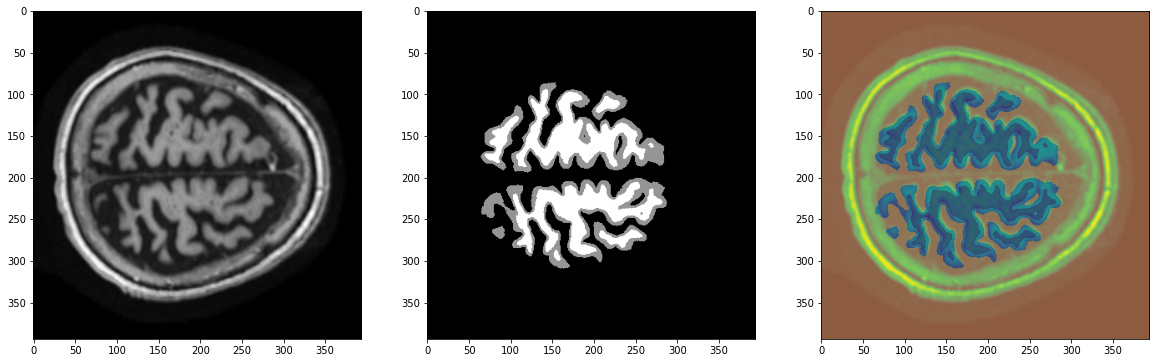

In [ ]:
#@title visualizar la imágen y máscara seleccionada para el test
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,12))
img1 = np.load(imgs[indexImg_rfc_A])
mask1 = np.load(masks[indexImg_rfc_A])
ax1.imshow(img, cmap='gray')
ax2.imshow(mask, cmap='Greys')
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [ ]:
#@title realizar una predicción con el modelo 
pred_rfc_a = rfc_a.predict(x_test_rfc_A.reshape(-1, 1))
accuracy_rfc_a = accuracy_score(pred_rfc_a, y_test_rfc_A)
recall_rfc_a = recall_score(y_test_rfc_A, pred_rfc_a, average='macro')
iou_metric_rfc_a = iou(pred_rfc_a, y_test_rfc_A)
print('accuracy: ', accuracy_rfc_a)
print('metrica IoU: ', iou_metric_rfc_a)
print('recall: ', recall_rfc_a)

accuracy:  0.7888148456661577
metrica IoU:  0.7888148456661577
recall:  0.5029316739879751


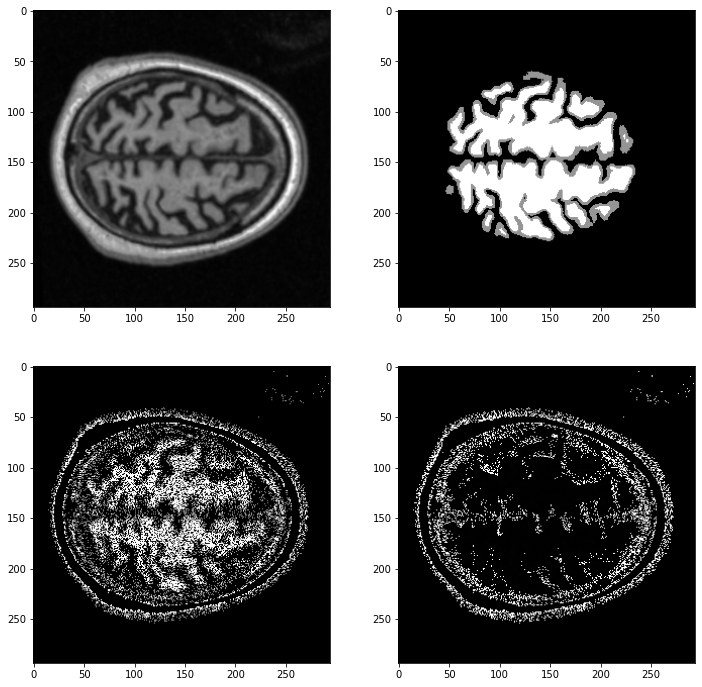

In [ ]:
#@title visualizar las imágenes de testeo y la predicción
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12,12))
ax1.imshow(x_test_rfc_A.reshape(NewSizeImagen), cmap='gray')
ax2.imshow(y_test_rfc_A.reshape(NewSizeImagen), cmap='Greys')
ax3.imshow(pred_rfc_a.reshape(NewSizeImagen), cmap='Greys')
ax4.imshow(pred_rfc_a.reshape(NewSizeImagen)-y_test_rfc_A.reshape(NewSizeImagen), cmap='gray')
plt.show()

###RFC Modelo B (entrenamiento con más de una imagen)

In [ ]:
#@title definir y entrenar el modelo
rfc_b = RandomForestClassifier(random_state=42, n_jobs=-1,
                                       n_estimators=8)
rfc_b.fit(x_train_B, y_train_B)

RandomForestClassifier(n_estimators=8, n_jobs=-1, random_state=42)

In [ ]:
#@title seleccionar una imágen y máscara para testear 
indexImg_rfc_A = 25 #@param {type:"int"})
x_test_rfc_A = imgsVector[indexImg_rfc_A]
y_test_rfc_A = masksVector[indexImg_rfc_A]

In [ ]:
#@title visualizar la imágen y máscara seleccionada para el test
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,12))
img1 = np.load(imgs[indexImg_rfc_A])
mask1 = np.load(masks[indexImg_rfc_A])
ax1.imshow(img, cmap='gray')
ax2.imshow(mask, cmap='Greys')
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [ ]:
#@title realizar una predicción con el modelo 
pred_rfc_b = rfc_b.predict(x_test_rfc_A.reshape(1, -1))
accuracy_rfc_b = accuracy_score(pred_rfc_b.reshape(-1, 1), y_test_rfc_A.reshape(-1, 1))
recall_rfc_b = recall_score(y_test_rfc_A.reshape(-1, 1), pred_rfc_b.reshape(-1, 1), average='macro')
iou_metric_rfc_b = iou(pred_rfc_b.reshape(-1, 1), y_test_rfc_A.reshape(-1, 1))
print('accuracy: ', accuracy_rfc_b)
print('metrica IoU: ', iou_metric_rfc_b)
print('recall: ', recall_rfc_b)

accuracy:  0.8451108334490258
metrica IoU:  0.8451108334490258
recall:  0.5484801068298317


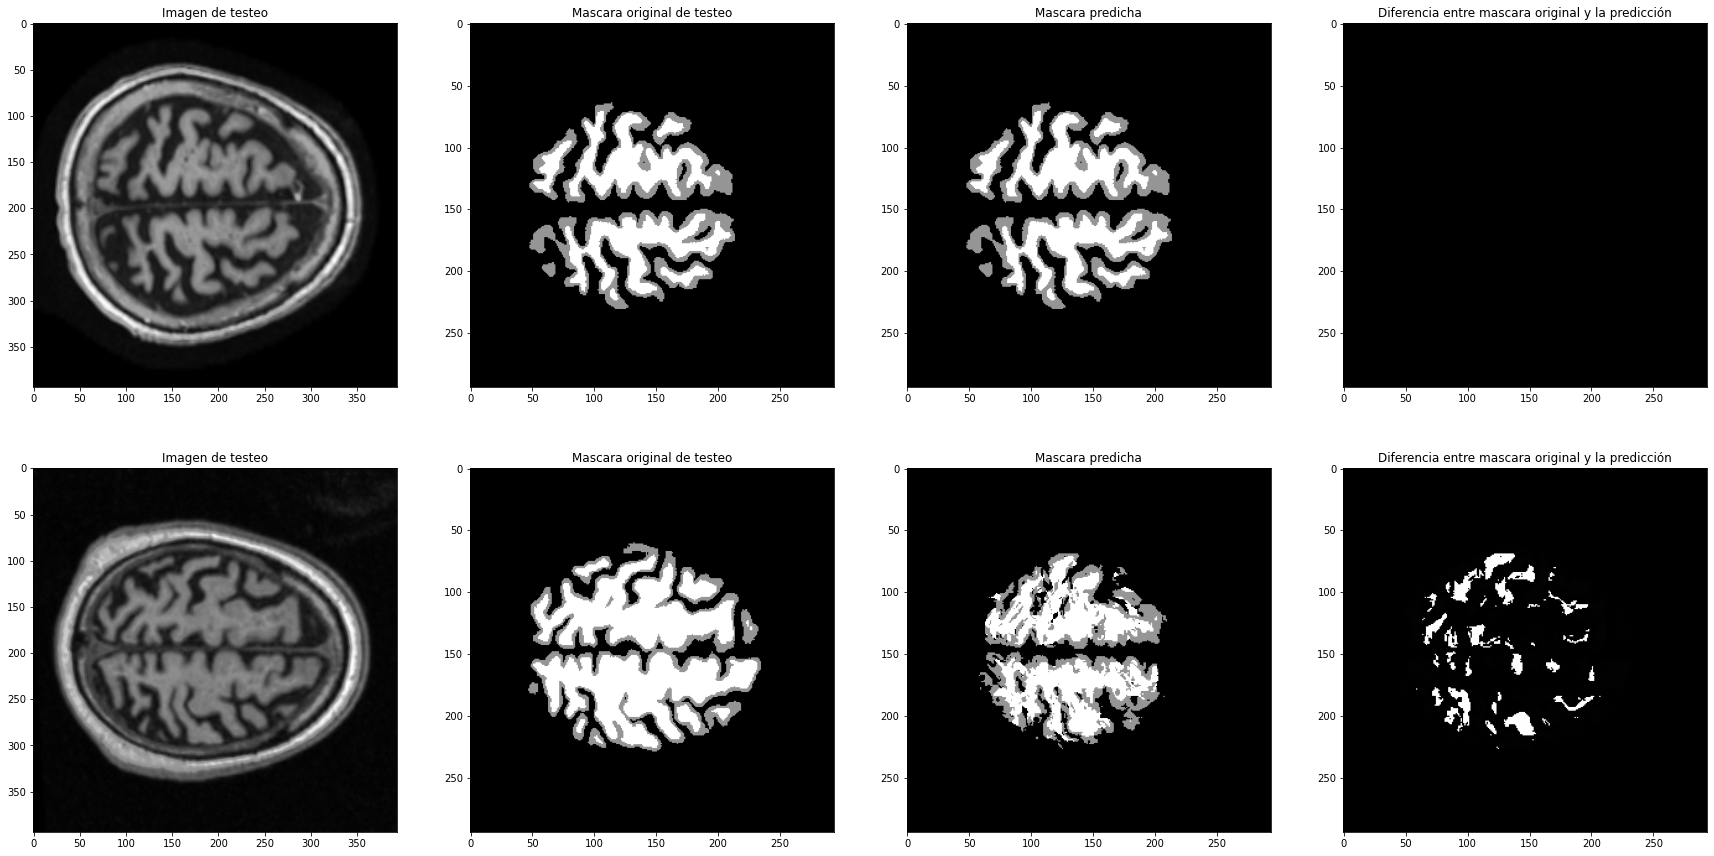

In [ ]:
fig, ([[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]]) = plt.subplots(2, 4, figsize=(30,15))
ax1.imshow(x_train_B[0].reshape(NewSizeImagen), cmap='gray')
ax2.imshow(y_train_B[0].reshape(NewSizeImagen), cmap='Greys')
ax3.imshow(rfc_b.predict(x_train_B[0].reshape(1, -1)).reshape(NewSizeImagen), cmap='Greys')
ax4.imshow(rfc_b.predict(x_train_B[0].reshape(1, -1)).reshape(NewSizeImagen)-y_train_B[0].reshape(NewSizeImagen), cmap='gray')
ax5.imshow(np.load(imgs[indexImg_test_dtc_B]), cmap='gray')
ax6.imshow(y_test_rfc_A.reshape(NewSizeImagen), cmap='Greys')
ax7.imshow(pred_rfc_b.reshape(NewSizeImagen), cmap='Greys')
ax8.imshow(pred_rfc_b.reshape(NewSizeImagen)-y_test_rfc_A.reshape(NewSizeImagen), cmap='gray')
ax1.set_title('Imagen de testeo')
ax2.set_title('Mascara original de testeo')
ax3.set_title('Mascara predicha')
ax4.set_title('Diferencia entre mascara original y la predicción')
ax5.set_title('Imagen de testeo')
ax6.set_title('Mascara original de testeo')
ax7.set_title('Mascara predicha')
ax8.set_title('Diferencia entre mascara original y la predicción')
plt.show()

YA VUELVO

##3. K-means

In [ ]:
#@title definir el modelo
n = 6
kmeans = KMeans(n_clusters=n, random_state=51)

In [ ]:
#@title seleccionar la imagen
indexImg_kmeans = 1 #@param {type:"int"})
img_km = np.load(imgs[indexImg_kmeans])
img_km_rs = img_km.reshape(img_km.shape[0]*img_km.shape[1],1)
img_km_rs.shape

(155236, 1)

In [ ]:
#@title entrenar el modelo
kmeans.fit(img_km_rs)
clustered = kmeans.cluster_centers_[kmeans.labels_]
labels = kmeans.labels_

In [ ]:
seg_img = labels.reshape(img_km.shape[0],img_km.shape[1])

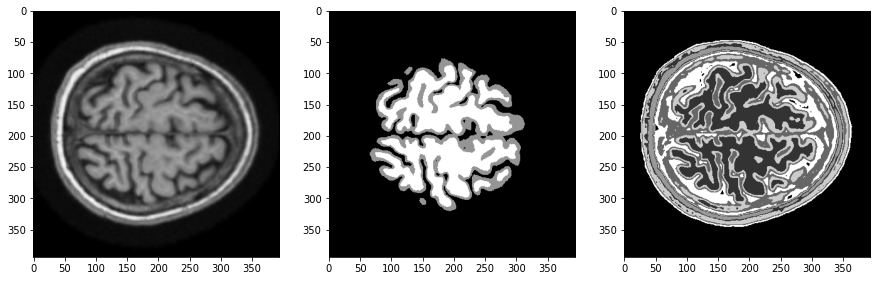

In [ ]:
#@title visualizar las imágenes de testeo y la predicción
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
ax1.imshow(img_km, cmap="gray")
ax2.imshow(np.load(masks[indexImg_kmeans]), cmap='Greys')
ax3.imshow(seg_img, cmap="gray")
plt.show()

In [ ]:
imagenes = []
for a in range(n):
    image_cluster = []
    for i in range(len(labels)):
        if(labels[i] == a):
            image_cluster.append(0)
        else:
            image_cluster.append(1)
    reshape_clustered = np.array(image_cluster).reshape(img_km.shape)
    imagenes.append(reshape_clustered)

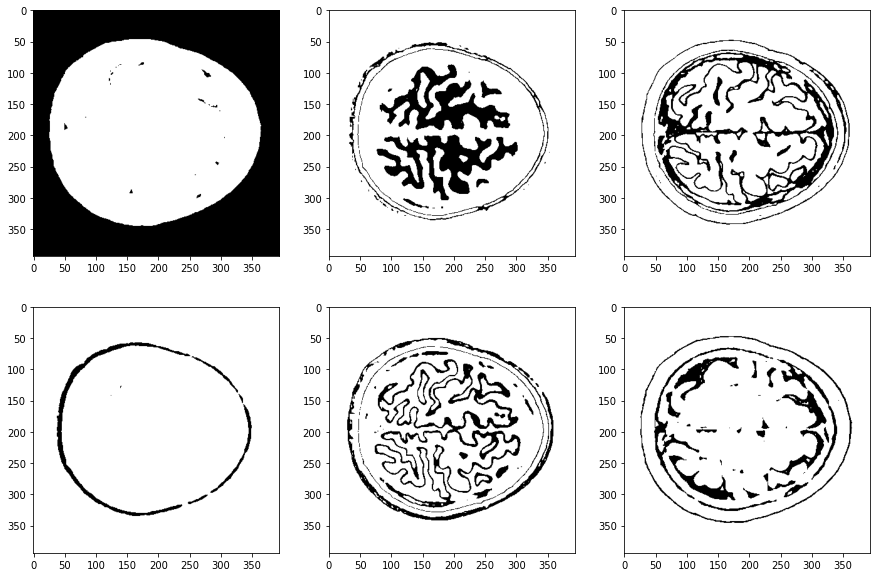

In [ ]:
fig, ([ax1, ax2, ax3],[ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(15,10))
ax1.imshow(imagenes[0], cmap="gray")
ax2.imshow(imagenes[1], cmap="gray")
ax3.imshow(imagenes[2], cmap="gray")
ax4.imshow(imagenes[3], cmap="gray")
ax5.imshow(imagenes[4], cmap="gray")
ax6.imshow(imagenes[5], cmap="gray")

# Integrantes del proyecto

- Daniel Felipe Castellanos Gelvez
- Daniel Felipe Jaimes Blanco
- Leider Eduardo Diaz Martinez

# **Referencias**

[1] MRIs Dataset: https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip 

[2] Clasificación de imágenes en Python con Keras: https://en.wikipedia.org/wiki/Sensitivity_and_specificity

[3] Segmentación: https://juansensio.com/blog/050_cv_segmentacion

[4] Machine learning: an introduction!: https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/-/blob/master/09_std_Notes_Classification.ipynb

[5] Machine Learning: More methods: https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/-/blob/master/10_std_Notes_ML_Methods.ipynb

